In [58]:
%matplotlib inline

# Setup and load demonstration data

A few machine learning and reinforcement libraries have been developped. For instance, you can look at :

*    stable baselines: short documentation at https://stable-baselines.readthedocs.io/_/downloads/en/v2.4.0/pdf/ ; long documentation for the version 3 at https://stable-baselines3.readthedocs.io/en/master/guide/rl.html. There is also a page dedicated to imitation on https://stable-baselines3.readthedocs.io/en/master/guide/imitation.html
*    rlkit library developped by berkeley,. It proposes a reinforcement learning framework and algorithms implemented in PyTorch. The repository is on https://github.com/vitchyr/rlkit/



The imitation library implements imitation learning algorithms on top of Stable-Baselines3, including:

*        Behavioral Cloning

*       DAgger with synthetic examples

*        Adversarial Inverse Reinforcement Learning (AIRL)

*        Generative Adversarial Imitation Learning (GAIL)




It also provides CLI scripts for training and saving demonstrations from RL experts, and for training imitation learners on these demonstrations.


We will follow the code proposed in https://stable-baselines3.readthedocs.io/en/master/guide/imitation.html.

For more documentation on stable-baselines, see :
* https://stable-baselines3.readthedocs.io/en/master/guide/quickstart.html
* https://stable-baselines3.readthedocs.io/en/master/guide/algos.html shows a guide to the implemented algorithms
* https://github.com/DLR-RM/stable-baselines3 for the code of stable-baselines

In [59]:
!pip install stable_baselines --upgrade
!pip install imitation


In [60]:
# Libraries
# Colab libraries
from google.colab import drive
from google.colab import output
drive.mount('/content/gdrive')
colab_path = "/content/gdrive/My Drive/Colab Notebooks/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Download the file https://raw.githubusercontent.com/HumanCompatibleAI/imitation/master/tests/data/expert_models/cartpole_0/rollouts/final.pkl and put it in your google drive Colab Notebook folder.

In [61]:
import sys
%cd $colab_path
sys.path.append('.'); sys.argv=['']

/content/gdrive/My Drive/Colab Notebooks


In [62]:
"""Loads CartPole-v1 demonstrations and trains BC and GAIL models on that data.
"""

import pathlib
import pickle
import tempfile

import stable_baselines3 as sb3

from imitation.algorithms import adversarial, bc
from imitation.data import rollout
from imitation.util import logger, util

# Load pickled test demonstrations.
with open("expert_data_CartPole.pkl", "rb") as f:
    # This is a list of `imitation.data.types.Trajectory`, where
    # every instance contains observations and actions for a single expert
    # demonstration.
    trajectories = pickle.load(f)

# Convert List[types.Trajectory] to an instance of `imitation.data.types.Transitions`.
# This is a more general dataclass containing unordered
# (observation, actions, next_observation) transitions.
transitions = rollout.flatten_trajectories(trajectories)

venv = util.make_vec_env("CartPole-v1", n_envs=2)

tempdir = tempfile.TemporaryDirectory(prefix="quickstart")
tempdir_path = pathlib.Path(tempdir.name)
print(f"All Tensorboards and logging are being written inside {tempdir_path}/.")


All Tensorboards and logging are being written inside /tmp/quickstartjdjyruxv/.


In [63]:
#information about transitions
print("type of transitions" ,type(transitions))
print("length of transitions ", len(transitions))
print("first transition ",transitions[0])

type of transitions <class 'imitation.data.types.Transitions'>
length of transitions  27976
first transition  {'obs': array([ 0.03013294,  0.0351516 ,  0.00868224, -0.02005102]), 'acts': 0, 'infos': {}, 'next_obs': array([ 0.03083597, -0.16009378,  0.00828122,  0.27535856]), 'dones': False}


# Behavioral Cloning

See the deprecated documentation for more detail about the implementation https://stable-baselines.readthedocs.io/en/master/guide/pretrain.html

In [64]:
# Train Behavioral Cloning on expert data.
# BC also accepts as `expert_data` any PyTorch-style DataLoader that iterates over
# dictionaries containing observations and actions.
logger.configure(tempdir_path / "BC/")
bc_trainer = bc.BC(venv.observation_space, venv.action_space, expert_data=transitions)

Logging to /tmp/quickstartjdjyruxv/BC


Install rendering libraries and gym

In [65]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay

Create a virtual display (only necessary in a notebook)

In [66]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [67]:
import matplotlib.pyplot as plt
import gym
import numpy as np


Initialise the simulation environment

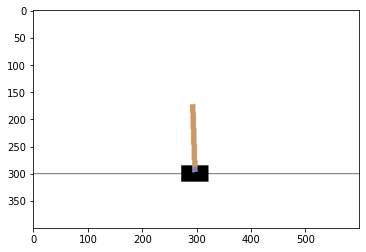

In [68]:
env = gym.make("CartPole-v0")
#env = gym.make("BipedalWalker-v3") # try for different environements
#env = gym.make('MountainCarContinuous-v0')
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

Print out the properties of the environment


In [69]:
print(venv.action_space)
print(venv.observation_space)

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


##Before training
Test in the environment the untrained policy.  
TODO: write the code to test the behaviour of the output policy on the environment. We will be able to select the action of the environment with

    a,_ = bc_trainer.policy.predict(s)

In [70]:
num_episodes = 10
rew_list=[]
for i in range(num_episodes):
    #TODO: write the code to test the behaviour of the output policy on the environment for num_episodes 
    rAll = 0
    done = False
    obs = env.reset()
    while done == False :
        a,_ = bc_trainer.policy.predict(obs)
        obs, reward, done, _ = env.step(a)
        rAll += reward
    rew_list.append(rAll)
    
print('Complete')

Complete


Plot the reward received by the bc_trainer

mean reward  19.1


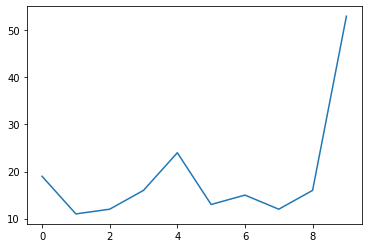

In [71]:
#check the learning process by plotting  the reward per episode 
plt.plot(rew_list)
print("mean reward ",np.mean(rew_list))

##After Training
Train the policy by behavioural cloning after training for 1 epoch

In [72]:
bc_trainer.train(n_epochs=1) 

BC epoch:   0%|          | 0/1 [00:00<?, ?it/s]

-----------------------------
| batch_size    | 32        |
| ent_loss      | -0.000509 |
| entropy       | 0.509     |
| epoch_num     | 0         |
| l2_loss       | 0         |
| l2_norm       | 42.3      |
| loss          | 0.443     |
| n_updates     | 100       |
| neglogp       | 0.443     |
| prob_true_act | 0.695     |
-----------------------------
-----------------------------
| batch_size    | 32        |
| ent_loss      | -0.000459 |
| entropy       | 0.459     |
| epoch_num     | 0         |
| l2_loss       | 0         |
| l2_norm       | 44.8      |
| loss          | 0.329     |
| n_updates     | 200       |
| neglogp       | 0.33      |
| prob_true_act | 0.749     |
-----------------------------
-----------------------------
| batch_size    | 32        |
| ent_loss      | -0.000475 |
| entropy       | 0.475     |
| epoch_num     | 0         |
| l2_loss       | 0         |
| l2_norm       | 46.5      |
| loss          | 0.611     |
| n_updates     | 300       |
| neglogp 

Test in the environment the output policy.

TODO: write the code to test the behaviour of the output policy on the environment and plot the rewards received. We will be able to select the action of the environment with 

      a,_ = bc_trainer.policy.predict(s)

In [73]:
snum_episodes = 10
rew_list=[]
for i in range(num_episodes):  
    #TODO: write the code to test the behaviour of the output policy on the environment for num_episodes 
    observation = env.reset()
    done, state = False, None
    epis_len = 0
    rAll = 0
    while not done:
        action, state = bc_trainer.policy.predict(observation, state=state,
                                                  deterministic=True)
        observation, reward, done, _info = env.step(action)
        rAll += reward
        epis_len += 1
        env.render()
    rew_list.append(rAll)
    
print('Complete')

Complete


mean reward  200.0


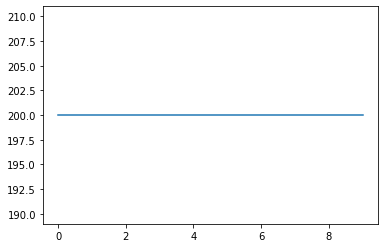

In [74]:
#check the learning process by plotting  the reward per episode 
plt.plot(rew_list)
print("mean reward ",np.mean(rew_list))

#Generative Adversarial Imitation Learning
Let us train with the algoirthm GAIL. See the  documentation and examples from : 


*  https://github.com/HumanCompatibleAI/imitation/tree/master/examples
*  https://stable-baselines3.readthedocs.io/en/master/guide/imitation.html
*  (deprecated) https://stable-baselines.readthedocs.io/en/v2.4.0/modules/gail.html 

GAIL relies on a RL algorithm in its inner loop. One option is the algorithm PPO, which is a policy gradient algorithm (see a short explanation in https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)

TODO: implement GAIL for the cartpole on the same expert data. Report the rewards with respect to the number of traning time steps. Comment the results and contrast with the results from Behaviour Cloning.

In [75]:
# import
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

# Train GAIL on expert data.
# GAIL also accepts as `expert_data` any Pytorch-style DataLoader that
# iterates over dictionaries containing observations, actions, and next_observations.
logger.configure(tempdir_path / "GAIL/")

#TODO: implement GAIL for the cartpole on the loaded expert data
gail_learner = PPO(env=venv, policy=MlpPolicy, batch_size=64, ent_coef=0.0,
              learning_rate=0.0003, n_epochs=10)

gail_trainer = adversarial.GAIL(venv=venv, expert_data=transitions,
                                gen_algo=gail_learner, expert_batch_size=1024)

Logging to /tmp/quickstartjdjyruxv/GAIL


Test in the environment the output policy.

TODO: write the code to test the behaviour of the output policy on the environment. We will be able to select the action of the environment with 

      a,_ = gail_trainer.gen_algo.predict(s)

In [76]:
num_episodes = 10
rew_list=[]
for i in range(num_episodes):
    #TODO: write the code to test the behaviour of the output policy on the environment for num_episodes 
    observation = env.reset()
    done, state = False, None
    rAll = 0.0
    epis_len = 0
    while not done:
        action, state = gail_trainer.gen_algo.predict(observation, state=state, deterministic=True)
        observation, reward, done, _info = env.step(action)
        rAll += reward
        epis_len += 1
        env.render()
    rew_list.append(rAll)
    
print('Complete')

Complete


mean reward  9.9


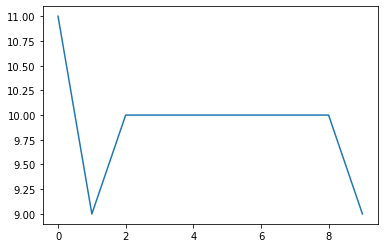

In [77]:
#check the learning process by plotting  the reward per episode 
plt.plot(rew_list)
print("mean reward ",np.mean(rew_list))

# A Robot environment with Pybullet

You can use a robot using pybullet physical simulator. Documentation about pybullet can be read on https://pybullet.org/wordpress/index.php/forum-2/.
Below is an example of code to use a robot arm or a humanoid agent.

In [78]:
#INSTALL THE PACKAGES
!pip3 install pybullet --upgrade
!pip3 install stable_baselines --upgrade
!pip3 install tensorflow==1.14.0 #tensorflow deprecates and breaks their API
#see PyBullet Quickstart Guide at
#https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit
!pip3 install pyvirtualdisplay > /dev/null 2>&1

In [79]:
#connect to the physical simulator
import pybullet
import pybullet_data
datapath = pybullet_data.getDataPath()
pybullet.connect(pybullet.DIRECT)

4

PyBullet offers several robotics environments. 

The implementation of the Kuka robot arm can be found in https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/bullet/kukaGymEnv.py.

The implementation of the humanoid, ant ... can be found in https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/gym_locomotion_envs.py. 

The implementation fo the reacher can be found in https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/gym_manipulator_envs.py

Documentation on the mujoco humanoid environment is : https://github.com/openai/gym/wiki/Humanoid-V1

You can also find a documentation on PyBullet on https://usermanual.wiki/Document/PyBullet20Quickstart20Guide.543993445/html or https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.2ye70wns7io3, including the API functions to control the robot from page 18. 


Below is an example code to run the Humanoid environment

In [80]:
import gym
import time
import pybullet_envs

#Below are a few examples of agents in pybullet
env = gym.make("HumanoidBulletEnv-v0")
# env = gym.make("AntBulletEnv-v0")
# env = gym.make("HalfCheetahBulletEnv-v0")
# env = gym.make('ReacherBulletEnv-v0')

# env = gym.make("KukaBulletEnv-v0") #KUKA robot arm grasping environments
#https://programmersought.com/article/69341201576/
#The environment uses the KUKA liwa robotic arm with the goal of grabbing objects placed in the tray. When the robot arm grabs the target to a certain height, the system is rewarded. In order to optimize the entire crawling process, a small amount of reward is given based on the distance between the action, the gripper and the target. The observed value (ie, state) is represented by the coordinate value (x, y) of the target.
#The observations in KukaCamBulletEnv-v0 are represented by camera pixel values, and the others are identical to the previous version (ie camera pixels).
#https://colab.research.google.com/github/mahyaret/kuka_rl/blob/master/kuka_rl_2.ipynb
#https://github.com/mahyaret/kuka_rl


# env = gym.make("CartPoleBulletEnv-v0")


# Display information about the environment
aspace = env.action_space
ospace = env.observation_space
print("The action space is {}".format(aspace))
print("The dimension of the action space is {}".format(aspace.shape[0]))
print("The observation space is {}".format(ospace))
#env.render(mode="human")
obs= env.reset()
print("obs ",obs)
obs= env.reset()
print("obs ",obs)
obs= env.reset()
print("obs ",obs)
images = []

The action space is Box(-1.0, 1.0, (17,), float32)
The dimension of the action space is 17
The observation space is Box(-inf, inf, (44,), float32)
obs  [ 5.99999964e-01  1.63450079e-06  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  2.28841160e-03  0.00000000e+00  3.74641627e-01  0.00000000e+00
  1.42730894e-02  0.00000000e+00  6.13931894e-01  0.00000000e+00
  2.02969238e-01  0.00000000e+00  7.48445868e-01  0.00000000e+00
  9.90669250e-01  0.00000000e+00  7.96555042e-01  0.00000000e+00
  2.01130629e-01  0.00000000e+00  7.09955096e-01  0.00000000e+00
  1.06856418e+00  0.00000000e+00  1.16157249e-01  0.00000000e+00
  2.01716155e-01  0.00000000e+00  3.06338549e-01  0.00000000e+00
 -1.86082467e-01  0.00000000e+00 -1.23348236e-01  0.00000000e+00
  2.90334880e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
obs  [ 5.99999964e-01  1.05050922e-05  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+

To display a simulated episode.

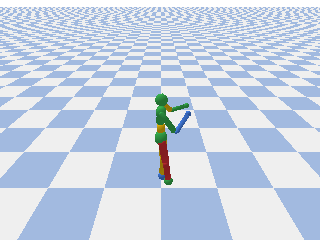

In [81]:
#run an episode of 20 steps
#while True:
for i in range(20):
    #env.render(mode="human")
    time.sleep(0.01)
    action = env.action_space.sample()
    # print("action: {}".format(action))
    observation, _, done, info = env.step(action)
    img = env.render(mode='rgb_array')
    images.append(img)
    
    
#display the video
from IPython.display import Image
!pip3 install numpngw
from numpngw import write_apng

#imageio.mimsave('a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
write_apng('anim.png', images, delay=20)
Image(filename='anim.png')

TODO : Train your agent with an algorithm of your choice. You can implement yourself the algorithm or use stable_baselines library. Report the performance of your agent by plotting the reward with respect to the training steps.

In [82]:
#TODO : Train your agent with an algorithm of your choice and report the performance

# Use the trained agent as a new expert

TODO : use the previously trained agent to constitute an expert dataset

In [83]:
#TODO : obtain a demonstration dataset from the previously trained agent

# IMITATION LEARNING from the new expert

TODO: implement an imitation learning of your choice for the same agent and environment. You can implement yourself the algorithm or use stable_baselines library. Using the new demonstration dataset, report the performance of your agent. Compare this performance to the performance of the new expert.

In [84]:
#TODO: implement an imitation learning of your choice for the same agent and environment. 
#TODO: Using the new demonstration dataset, report the performance of your agent.